In [ ]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 1. Generate a 2D Gaussian Filter for MSSIM
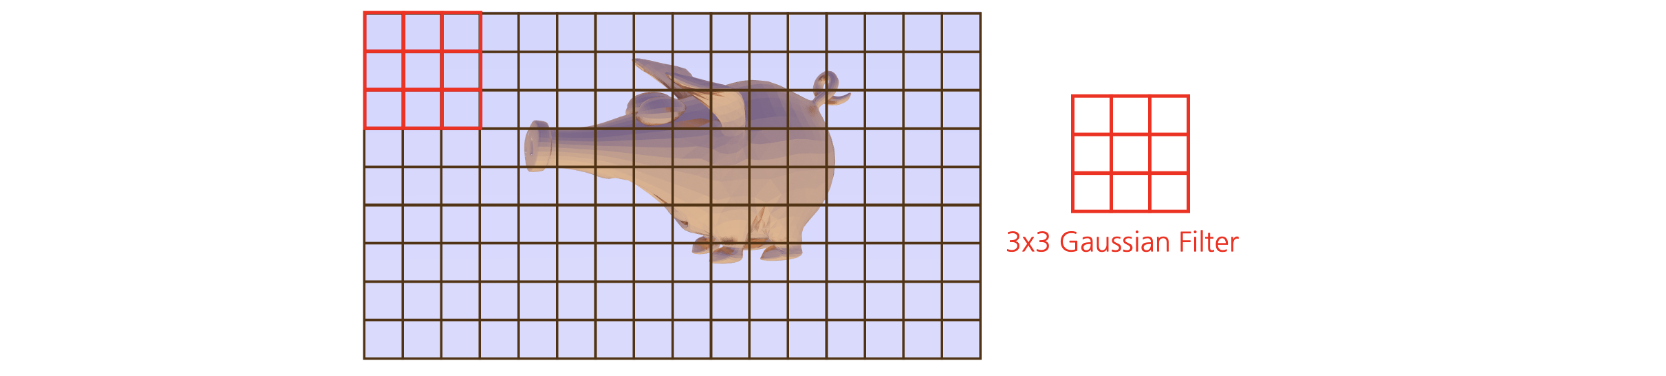

In [ ]:
# guassian(): generates a Tensor from a Gaussian distribution (size: window_size)
def gaussian(window_size, sigma):
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

# Check if gaussian() works fine
gauss_dis = gaussian(11, 1.5)
print("Distribution: ", gauss_dis)
print("Sum of Gauss Distribution:", torch.sum(gauss_dis))  # sum of all values should be 1

# create_window(): creates a 2D Gaussian filter with the Gaussian Tensor
def create_window(window_size, channel=1):
    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Convert the 1D tensor to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

window = create_window(11, 3)
print("Shape of gaussian window:", window.shape)

Distribution:  tensor([0.0010, 0.0076, 0.0360, 0.1094, 0.2130, 0.2660, 0.2130, 0.1094, 0.0360,
        0.0076, 0.0010])
Sum of Gauss Distribution: tensor(1.)
Shape of gaussian window: torch.Size([3, 1, 11, 11])


# 2. Compute the MSSIM of two images
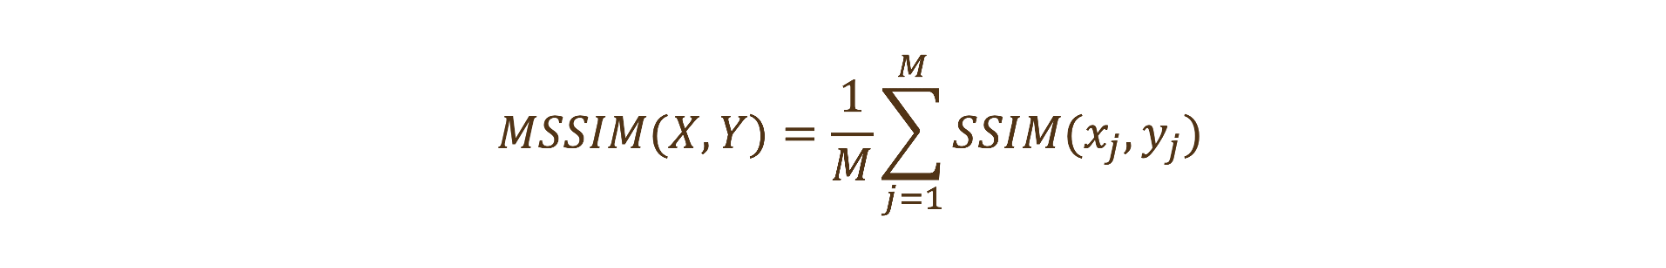
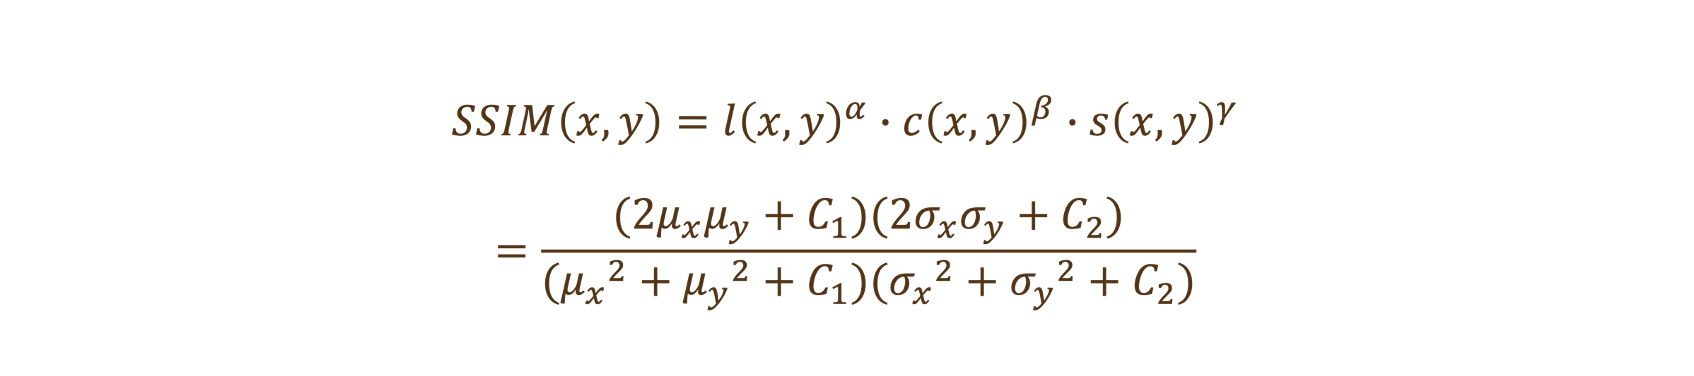

In [ ]:
# mssim(): computes a MSSIM value of two images
def mssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # If a window is not provided, generate one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # Calculate local mu(luminance) parameters using Gaussian filter
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)  # mu of image 1
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)  # mu of image 2
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # Calculate local sigma(Contrast) square parameters
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    # parameters of SSIM formula
    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    # Compute the MSSIM score
    mssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = mssim_score.mean() 
    else: 
        ret = mssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

# Load images and compute the MSSIM score.

In [ ]:

# helper function to load images

# Image Size
img_width = 400
aspect_ratio = 9.0/16.0
# img_height = img_width * aspect_ratio
img_height = 225

load_images = lambda x: np.asarray(Image.open(x).resize((img_width, img_height)))

# helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display_imgs(): displays images
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (img_width, img_height))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

# Change ppm images to PNG format


In [ ]:
from PIL import Image
import os


# Load Images
directory = "/content/gdrive/MyDrive/cpfloat_emulator/"
img = {}

os.chdir("/content/gdrive/MyDrive/cpfloat_emulator")



for filename in os.listdir('.'):
  if filename.endswith(".ppm"):
    with Image.open(filename) as im:
      im.save(os.path.splitext(filename)[0] + '.png')

In [ ]:
#Load images from drive
for exp in range(5, 12):
  for mant in range(4, 31):
    precision = str(exp) + "_" + str(mant)
    filename = "d_"+ precision + "_400_10_50_img.png"
    img[precision] = tensorify(load_images(filename))

img["11_52"] = tensorify(load_images("d_11_52_400_10_50_img.png"))

In [ ]:
# Compare FP64 and FP32
ssim = {i: {} for i in range(5, 12)}
fp64_img = img["11_52"]

for precision in img.keys():
  mssim_score = mssim(fp64_img, img[precision], val_range=255)
  exp, mant = map(int, precision.split("_"))
  ssim[exp][mant] = mssim_score.item()
  # print("[MSSIM] ", "FP64", " vs ",precision, mssim_score)

for exp in ssim.keys():
  print(ssim[exp])

{4: 0.0002057091478491202, 5: 0.0002057091478491202, 6: 0.0002057091478491202, 7: 0.0002057091478491202, 8: 0.0002057091478491202, 9: 0.0002057091478491202, 10: 0.0002057091478491202, 11: 0.0002057091478491202, 12: 0.0002057091478491202, 13: 0.0002057091478491202, 14: 0.0002057091478491202, 15: 0.0002057091478491202, 16: 0.0002057091478491202, 17: 0.0002057091478491202, 18: 0.0002057091478491202, 19: 0.0002057091478491202, 20: 0.0002057091478491202, 21: 0.0002057091478491202, 22: 0.0002057091478491202, 23: 0.0002057091478491202, 24: 0.0002057091478491202, 25: 0.0002057091478491202, 26: 0.0002057091478491202, 27: 0.0002057091478491202, 28: 0.0002057091478491202, 29: 0.0002057091478491202, 30: 0.0002057091478491202}
{4: 0.19022361934185028, 5: 0.27976560592651367, 6: 0.20022867619991302, 7: 0.18049392104148865, 8: 0.34709134697914124, 9: 0.44513216614723206, 10: 0.48348090052604675, 11: 0.5283220410346985, 12: 0.6212309002876282, 13: 0.575810432434082, 14: 0.6468505263328552, 15: 0.63075

In [ ]:
#TEST

from PIL import Image
import os


# Load Images
directory = "/content/gdrive/MyDrive/1000_50/"
test_img = {}

os.chdir("/content/gdrive/MyDrive/1000_50/")

for filename in os.listdir('.'):
  if filename.endswith("_400_1000_50_img.ppm"):
    with Image.open(filename) as im:
      im.save(os.path.splitext(filename)[0] + '.png')


cp_6_11_img = tensorify(load_images("d_6_11_400_1000_50_img.png"))
cp_6_15_img = tensorify(load_images("d_6_15_400_1000_50_img.png"))
fp32_img = tensorify(load_images("d_8_23_400_1000_50_img.png"))
fp64_img = tensorify(load_images("d_11_52_400_1000_50_img.png"))

mssim_score_6_11 = mssim(fp64_img, cp_6_11_img, val_range=255)
mssim_score_6_15 = mssim(fp64_img, cp_6_15_img, val_range=255)
mssim_score_fp32 = mssim(fp64_img, fp32_img, val_range=255)

print("[MSSIM] ", "FP64", " vs ","6_11", mssim_score_6_11)
print("[MSSIM] ", "FP64", " vs ","6_15", mssim_score_6_15)
print("[MSSIM] ", "FP64", " vs ","fp32", mssim_score_fp32)


[MSSIM]  FP64  vs  6_11 tensor(0.8078)
[MSSIM]  FP64  vs  6_15 tensor(0.9827)
[MSSIM]  FP64  vs  fp32 tensor(0.9899)


# 3. Generate SSIM Graph

**Graph type 1**

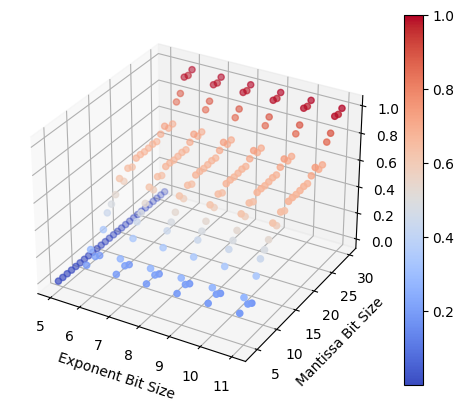

In [ ]:
#data
ssim = {
    5: {4: 0.0002057091478491202, 5: 0.0002057091478491202, 6: 0.0002057091478491202, 7: 0.0002057091478491202, 8: 0.0002057091478491202, 9: 0.0002057091478491202, 10: 0.0002057091478491202, 11: 0.0002057091478491202, 12: 0.0002057091478491202, 13: 0.0002057091478491202, 14: 0.0002057091478491202, 15: 0.0002057091478491202, 16: 0.0002057091478491202, 17: 0.0002057091478491202, 18: 0.0002057091478491202, 19: 0.0002057091478491202, 20: 0.0002057091478491202, 21: 0.0002057091478491202, 22: 0.0002057091478491202, 23: 0.0002057091478491202, 24: 0.0002057091478491202, 25: 0.0002057091478491202, 26: 0.0002057091478491202, 27: 0.0002057091478491202, 28: 0.0002057091478491202, 29: 0.0002057091478491202, 30: 0.0002057091478491202}, 
    6: {4: 0.19022361934185028, 5: 0.27976560592651367, 6: 0.20022867619991302, 7: 0.18049392104148865, 8: 0.34709134697914124, 9: 0.44513216614723206, 10: 0.48348090052604675, 11: 0.5283220410346985, 12: 0.6212309002876282, 13: 0.575810432434082, 14: 0.6468505263328552, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    7: {4: 0.19189925491809845, 5: 0.27933669090270996, 6: 0.20000305771827698, 7: 0.18126937747001648, 8: 0.34827280044555664, 9: 0.44505202770233154, 10: 0.482636421918869, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    8: {4: 0.19172638654708862, 5: 0.2776234447956085, 6: 0.20128948986530304, 7: 0.18116407096385956, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    9: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    10: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    11: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0, 52: 1.0}
}

#--------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a mesh grid of x and y values
x = np.array([i for i in range(5, 12) for _ in range(4, 31)])
y = np.array([i for _ in range(5, 12) for i in range(4, 31)])
z = np.array([ssim[exp][mant] for exp in range(5, 12) for mant in range(4, 31)])
X, Y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter= ax.scatter(x, y, z, c=z, cmap='coolwarm')

# # Connect the points with a line with the same x-value
# sorted_idx = np.argsort(x)
# ax.plot(x, y, z, 'b-')

# change grid color to black
ax.grid(True, color='black')

# set the labels for the axes
ax.set_xlabel('Exponent Bit Size')
ax.set_ylabel('Mantissa Bit Size')
ax.set_zlabel('MSSIM')

# show the plot
plt.colorbar(scatter)
plt.show()

**Graph type 2**

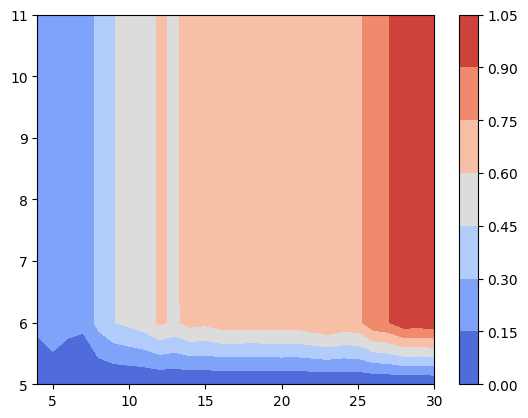

In [ ]:
#data
ssim = {
    5: {4: 0.0002057091478491202, 5: 0.0002057091478491202, 6: 0.0002057091478491202, 7: 0.0002057091478491202, 8: 0.0002057091478491202, 9: 0.0002057091478491202, 10: 0.0002057091478491202, 11: 0.0002057091478491202, 12: 0.0002057091478491202, 13: 0.0002057091478491202, 14: 0.0002057091478491202, 15: 0.0002057091478491202, 16: 0.0002057091478491202, 17: 0.0002057091478491202, 18: 0.0002057091478491202, 19: 0.0002057091478491202, 20: 0.0002057091478491202, 21: 0.0002057091478491202, 22: 0.0002057091478491202, 23: 0.0002057091478491202, 24: 0.0002057091478491202, 25: 0.0002057091478491202, 26: 0.0002057091478491202, 27: 0.0002057091478491202, 28: 0.0002057091478491202, 29: 0.0002057091478491202, 30: 0.0002057091478491202}, 
    6: {4: 0.19022361934185028, 5: 0.27976560592651367, 6: 0.20022867619991302, 7: 0.18049392104148865, 8: 0.34709134697914124, 9: 0.44513216614723206, 10: 0.48348090052604675, 11: 0.5283220410346985, 12: 0.6212309002876282, 13: 0.575810432434082, 14: 0.6468505263328552, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    7: {4: 0.19189925491809845, 5: 0.27933669090270996, 6: 0.20000305771827698, 7: 0.18126937747001648, 8: 0.34827280044555664, 9: 0.44505202770233154, 10: 0.482636421918869, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    8: {4: 0.19172638654708862, 5: 0.2776234447956085, 6: 0.20128948986530304, 7: 0.18116407096385956, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    9: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    10: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    11: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0, 52: 1.0}
}

ssim_array = []
for row in ssim.values():
  ssim_array_row = []
  for val in row.values():
    ssim_array_row.append(val)
  ssim_array.append(ssim_array_row)


#--------------------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# Define the x and y ranges
x = np.array([i for i in range(5, 12)])
y = np.array([i for i in range(4, 31)])

# # Create a meshgrid from the x and y ranges
# X, Y = np.meshgrid(x, y)

# Define the function to plot
def get_z_value(x, y, ssim):
  return ssim[x][y]
vec_get_z_value = np.vectorize(get_z_value)
z = vec_get_z_value(x.reshape(-1, 1), y, ssim)
z = z.reshape(x.shape[0], y.shape[0])

# Create the plot
plt.contourf(y, x, z, cmap='seismic')
plt.colorbar()

# Show the plot
plt.show()


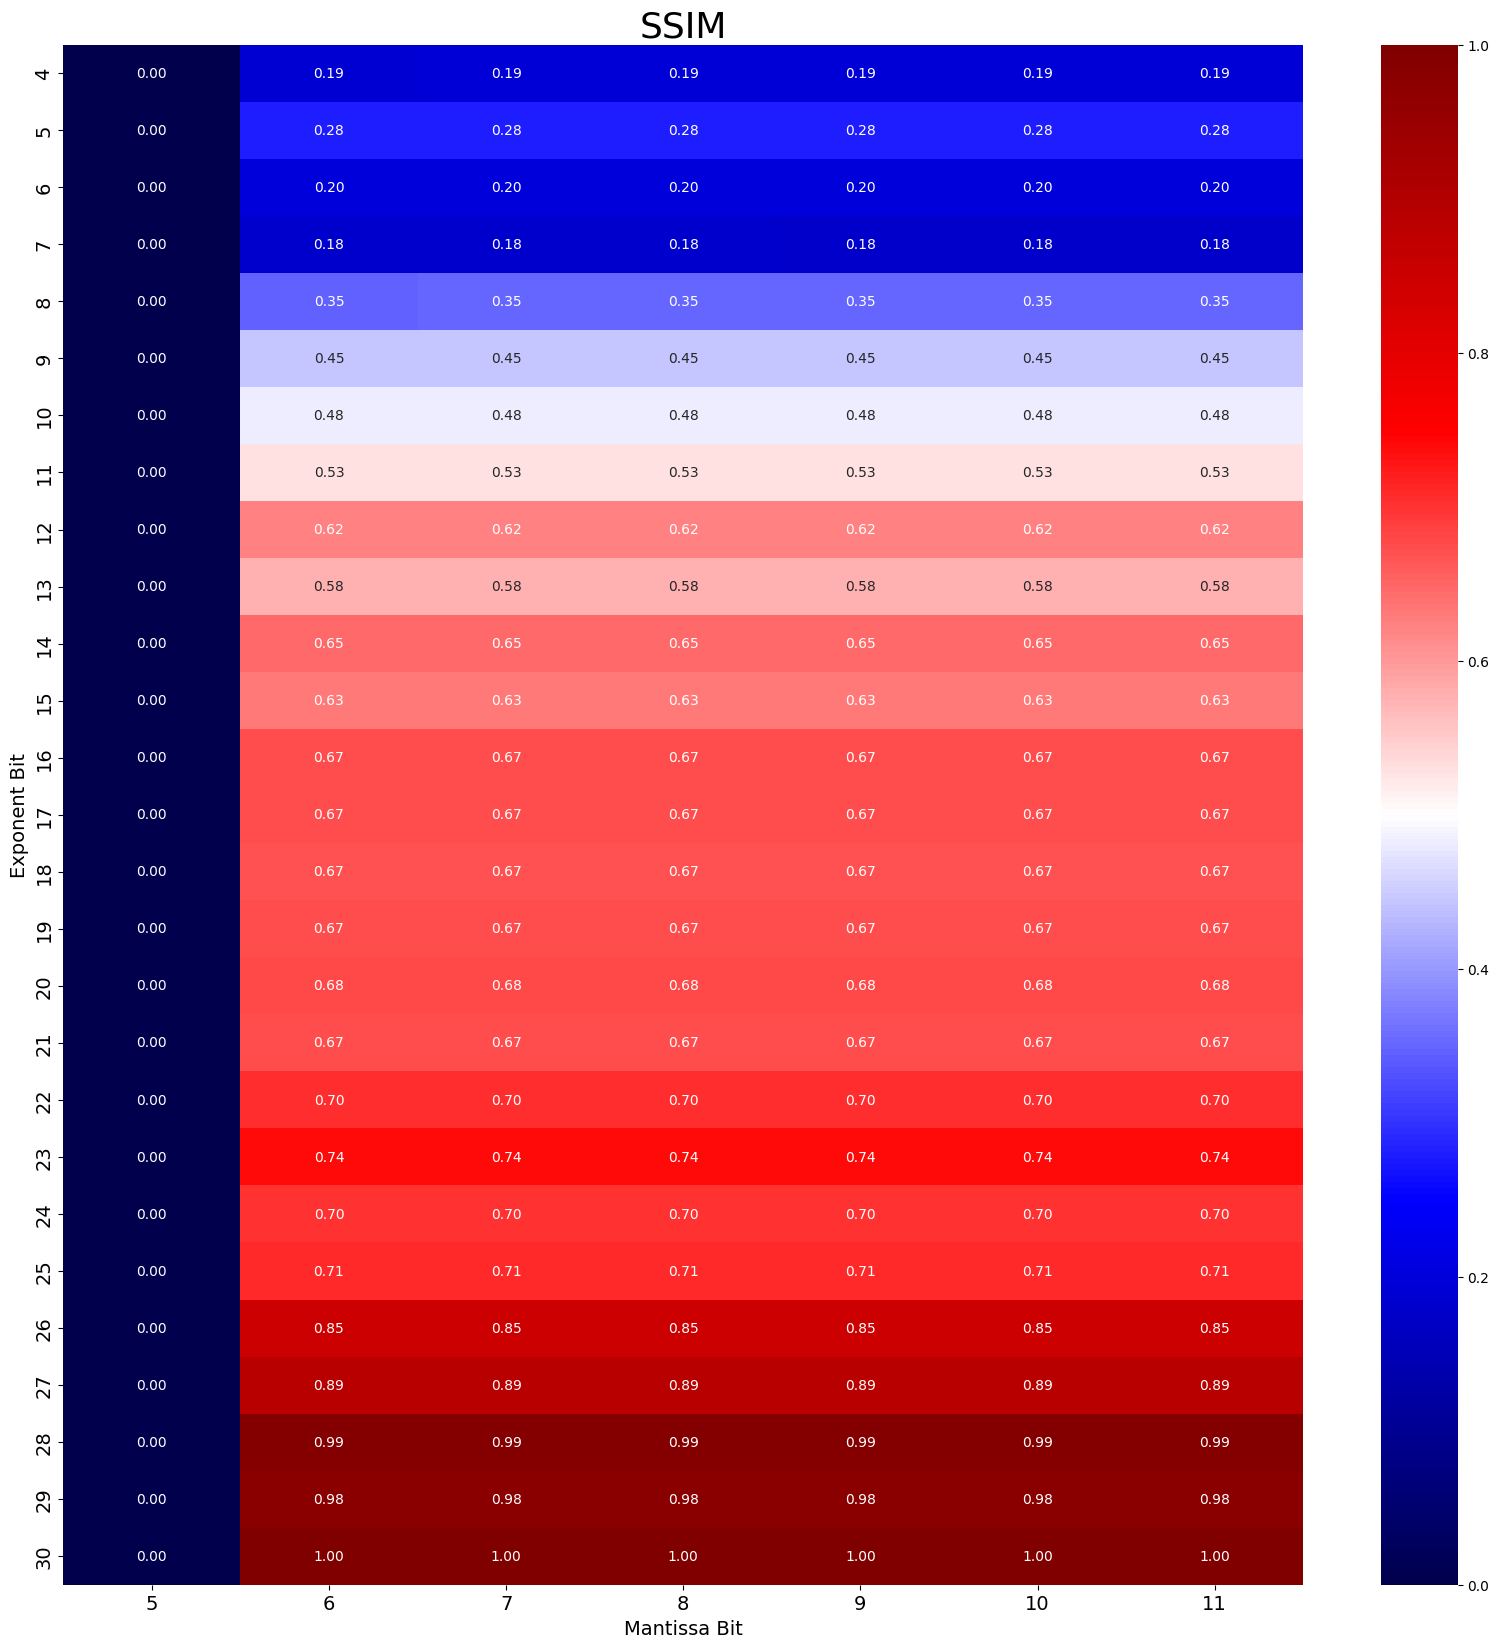

In [ ]:
#data
ssim = {
    5: {4: 0.0002057091478491202, 5: 0.0002057091478491202, 6: 0.0002057091478491202, 7: 0.0002057091478491202, 8: 0.0002057091478491202, 9: 0.0002057091478491202, 10: 0.0002057091478491202, 11: 0.0002057091478491202, 12: 0.0002057091478491202, 13: 0.0002057091478491202, 14: 0.0002057091478491202, 15: 0.0002057091478491202, 16: 0.0002057091478491202, 17: 0.0002057091478491202, 18: 0.0002057091478491202, 19: 0.0002057091478491202, 20: 0.0002057091478491202, 21: 0.0002057091478491202, 22: 0.0002057091478491202, 23: 0.0002057091478491202, 24: 0.0002057091478491202, 25: 0.0002057091478491202, 26: 0.0002057091478491202, 27: 0.0002057091478491202, 28: 0.0002057091478491202, 29: 0.0002057091478491202, 30: 0.0002057091478491202}, 
    6: {4: 0.19022361934185028, 5: 0.27976560592651367, 6: 0.20022867619991302, 7: 0.18049392104148865, 8: 0.34709134697914124, 9: 0.44513216614723206, 10: 0.48348090052604675, 11: 0.5283220410346985, 12: 0.6212309002876282, 13: 0.575810432434082, 14: 0.6468505263328552, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    7: {4: 0.19189925491809845, 5: 0.27933669090270996, 6: 0.20000305771827698, 7: 0.18126937747001648, 8: 0.34827280044555664, 9: 0.44505202770233154, 10: 0.482636421918869, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    8: {4: 0.19172638654708862, 5: 0.2776234447956085, 6: 0.20128948986530304, 7: 0.18116407096385956, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    9: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    10: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}, 
    11: {4: 0.19172638654708862, 5: 0.2776247262954712, 6: 0.2013884037733078, 7: 0.1787990778684616, 8: 0.34819263219833374, 9: 0.44505202770233154, 10: 0.4825834035873413, 11: 0.5283230543136597, 12: 0.6212247014045715, 13: 0.5759163498878479, 14: 0.6477824449539185, 15: 0.6307591199874878, 16: 0.6722955107688904, 17: 0.6737661957740784, 18: 0.6700290441513062, 19: 0.6730318665504456, 20: 0.6778140664100647, 21: 0.6727809309959412, 22: 0.7044321298599243, 23: 0.739869236946106, 24: 0.7013701796531677, 25: 0.7093853950500488, 26: 0.8504391312599182, 27: 0.8906202912330627, 28: 0.9891129732131958, 29: 0.9792642593383789, 30: 1.0}
}

import seaborn as sns
import matplotlib.pyplot as plt

# Convert the dictionary to a pandas dataframe
import pandas as pd
df = pd.DataFrame.from_dict(ssim)

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(20, 20))  #specify size of heatmap
sns.heatmap(df, vmin=0.0, vmax=1.0, linewidths=0.0, annot=True, fmt=".2f", cmap="seismic")  # annot: representing number

# Set colormap setting
#--------------------------------------------------------------------------
# Add map title
plt.title("SSIM", size=26)

# Set scale of x, y axis
plt.xticks(size=14, color = "black")
plt.yticks(size=14, color = "black")

# add axis labels
plt.xlabel("Mantissa Bit", size = 14)
plt.ylabel("Exponent Bit", size= 14)

#--------------------------------------------------------------------------

# Show the plot
plt.show()